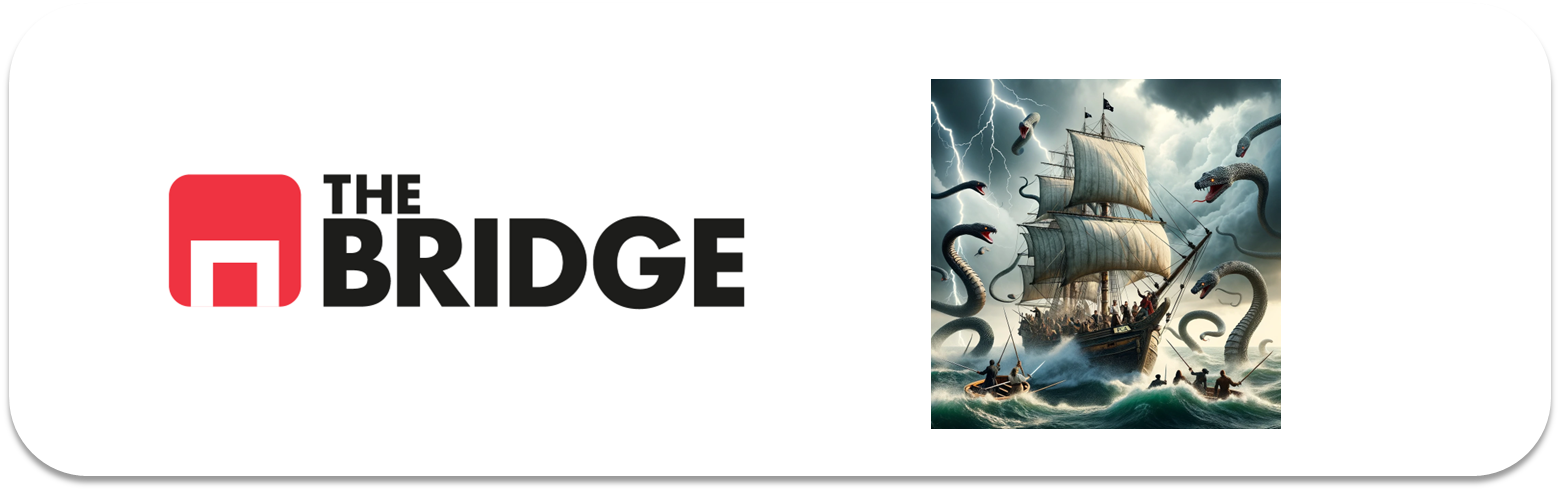

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, RFE, RFECV, SequentialFeatureSelector, SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, mutual_info_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from xgboost import XGBClassifier

from utils import datascience as ds
from utils import vizdatatools as viz

# import warnings library and ignore all warnings
# import warnings
# warnings.filterwarnings('ignore')

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificación sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


### 0. Objetivo

Es un problema de clasificación binaria (supervisado) sobre la variable "SeriousDlqin2yrs".

### 1. Cargar datos


In [2]:
df_credit = pd.read_csv('./data/credit_npo.csv')
df_credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [3]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

*Tirando de herramientas chatteras:*

1. **SeriousDlqin2yrs**: Variable dependiente/binaria. Indica si el individuo experimentó morosidad de 90 días o más en los próximos dos años al momento de la toma de datos. Un valor de 1 indica que sí experimentó dificultades financieras serias, y 0 en caso contrario.

2. **RevolvingUtilizationOfUnsecuredLines**: Proporción del crédito utilizado por el consumidor en relación con todas sus líneas de crédito disponibles sin garantía (como tarjetas de crédito).

3. **age**: Edad del prestatario en años.

4. **NumberOfTime30-59DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 30 y 59 días en sus pagos, pero no peor en los últimos 2 años.

5. **DebtRatio**: Relación deuda/ingreso. Es una medida de la carga de deuda del prestatario, calculada como sus pagos mensuales de deuda divididos por su ingreso mensual.

6. **MonthlyIncome**: Ingreso mensual del prestatario.

7. **NumberOfOpenCreditLinesAndLoans**: Número de préstamos abiertos y líneas de crédito (como préstamos para automóviles, hipotecas, préstamos personales, etc.).

8. **NumberOfTimes90DaysLate**: Número de veces que el prestatario ha estado retrasado más de 90 días en sus pagos.

9. **NumberRealEstateLoansOrLines**: Número de préstamos o líneas de crédito inmobiliarios, incluyendo hipotecas y líneas de crédito con garantía hipotecaria.

10. **NumberOfTime60-89DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 60 y 89 días en sus pagos, pero no peor en los últimos 2 años.

11. **NumberOfDependents**: Número de dependientes que el prestatario tiene en su familia, excluyéndose a sí mismo.



#### Limpieza de valores NaN

In [4]:
# Borrar todas las filas con valores NaN
df_credit.dropna(inplace=True)

In [5]:
ds.get_cardinality(df_credit, threshold_categorical=50)

pandas.DataFrame shape:  (11816, 11)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
SeriousDlqin2yrs,2,0.016926,0,0.0,int64,Binary
RevolvingUtilizationOfUnsecuredLines,10314,87.288422,0,0.0,float64,Numeric - Continuous
age,78,0.660122,0,0.0,int64,Numeric - Discrete
NumberOfTime30-59DaysPastDueNotWorse,10,0.084631,0,0.0,int64,Categoric
DebtRatio,11472,97.088693,0,0.0,float64,Numeric - Continuous
MonthlyIncome,4167,35.265741,0,0.0,float64,Numeric - Continuous
NumberOfOpenCreditLinesAndLoans,43,0.363913,0,0.0,int64,Categoric
NumberOfTimes90DaysLate,13,0.11002,0,0.0,int64,Categoric
NumberRealEstateLoansOrLines,16,0.13541,0,0.0,int64,Categoric
NumberOfTime60-89DaysPastDueNotWorse,8,0.067705,0,0.0,int64,Categoric


### Modificar las features categóricas que contienen la palabra "Number"

In [6]:
features_with_NumberOf = df_credit.filter(like='Number').columns
features_with_NumberOf

Index(['NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [7]:
for feat in features_with_NumberOf:
    print(df_credit[feat].value_counts(), end='\n---------\n')

NumberOfTime30-59DaysPastDueNotWorse
0     9818
1     1354
2      397
3      127
4       64
5       23
6       20
98      10
8        2
7        1
Name: count, dtype: int64
---------
NumberOfOpenCreditLinesAndLoans
7     1110
6     1031
8     1009
9      965
5      963
4      848
10     765
11     719
3      638
12     574
13     454
2      445
14     365
15     338
1      307
16     236
17     216
18     151
19     129
20     118
0      112
21      62
22      61
23      39
24      38
25      30
26      19
27      16
28      13
29      10
30      10
31       7
33       4
32       3
34       2
35       2
48       1
41       1
49       1
43       1
36       1
38       1
40       1
Name: count, dtype: int64
---------
NumberOfTimes90DaysLate
0     11156
1       394
2       142
3        54
4        31
5        14
98       10
6         6
8         3
7         3
10        1
9         1
13        1
Name: count, dtype: int64
---------
NumberRealEstateLoansOrLines
0     4233
1     4149
2     258

### Reducir la cardinalidad de las varaibles categóricas

Le estrategia que voy a usar es:

- Para NumberOfOpenCreditLinesAndLoans, podríamos agrupar el número de líneas de crédito y préstamos abiertos en pocas categorías, como:
    - 0-5 líneas (bajo) --> 0
    - 6-10 líneas (medio) --> 1
    - 11 o más líneas (alto) -->2

- Para NumberRealEstateLoansOrLines. Similarmente, podríamos agrupar el número de préstamos relacionados con bienes inmuebles en:
    - 0 préstamos (ninguno) --> 0
    - 1-2 préstamos (bajo) --> 1
    - 3 o más préstamos (alto) --> 2

- Para NumberOfDependents:
    - No hay dependientes --> 0
    - Hay 1-2 dependientes --> 1
    - Hay 3 o más dependientes --> 2

- Para todas las columnas que incluyen "NumberOfTime":
    - Si el valor es 0 --> 0
    - Si el valor es 1 --> 1
    - Para cualquier otro valor mayor que 1 --> 2


In [8]:
# Back-up
df_credit_bck = df_credit.copy()

In [9]:
# Mapeo de las columnas que necesitan ser convertidas a categorías
for feature in features_with_NumberOf:
    if feature == 'NumberOfDependents' or feature == 'NumberRealEstateLoansOrLines':
        df_credit[feature] = df_credit[feature].map(lambda x: 0 if x == 0 else 1 if x <= 2 else 2)
    elif feature == 'NumberOfOpenCreditLinesAndLoans':
        df_credit[feature] = df_credit[feature].map(lambda x: 0 if x <= 5 else 1 if x <= 10 else 2)
    else:
        df_credit[feature] = df_credit[feature].map(lambda x: 0 if x == 0 else 1 if x == 1 else 2)


In [10]:
ds.get_cardinality(df_credit)

pandas.DataFrame shape:  (11816, 11)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
SeriousDlqin2yrs,2,0.016926,0,0.0,int64,Binary
RevolvingUtilizationOfUnsecuredLines,10314,87.288422,0,0.0,float64,Numeric - Continuous
age,78,0.660122,0,0.0,int64,Numeric - Discrete
NumberOfTime30-59DaysPastDueNotWorse,3,0.025389,0,0.0,int64,Categoric
DebtRatio,11472,97.088693,0,0.0,float64,Numeric - Continuous
MonthlyIncome,4167,35.265741,0,0.0,float64,Numeric - Continuous
NumberOfOpenCreditLinesAndLoans,3,0.025389,0,0.0,int64,Categoric
NumberOfTimes90DaysLate,3,0.025389,0,0.0,int64,Categoric
NumberRealEstateLoansOrLines,3,0.025389,0,0.0,int64,Categoric
NumberOfTime60-89DaysPastDueNotWorse,3,0.025389,0,0.0,int64,Categoric


In [11]:
df_credit.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000
mean,0.070244,0.335668,51.447698,0.223595,0.499708,6864.815420,1.026236,0.078368,0.713609,0.062796,0.560596
std,0.255568,0.365209,14.516270,0.531629,2.696067,11855.905437,0.765743,0.342433,0.590004,0.284960,0.673079
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034927,41.000000,0.000000,0.143456,3498.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179183,51.000000,0.000000,0.294748,5416.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587187,62.000000,0.000000,0.477414,8300.000000,2.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,6.000000,101.000000,2.000000,96.000000,702500.000000,2.000000,2.000000,2.000000,2.000000,2.000000


### Split train y validation

In [12]:
target = 'SeriousDlqin2yrs'

train_set, valid_set = train_test_split(df_credit, test_size=0.2, stratify=df_credit[target], random_state=42)

### 2. Mini-EDA

#### Elección inicial de features categóricas y numéricas

In [13]:
num_features = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']
cat_features = [feature for feature in train_set.columns if feature not in (num_features + [target])]

print(num_features)
print(cat_features)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']
['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


#### Ver distribución del target


In [14]:
train_set[target].value_counts()

SeriousDlqin2yrs
0    8788
1     664
Name: count, dtype: int64

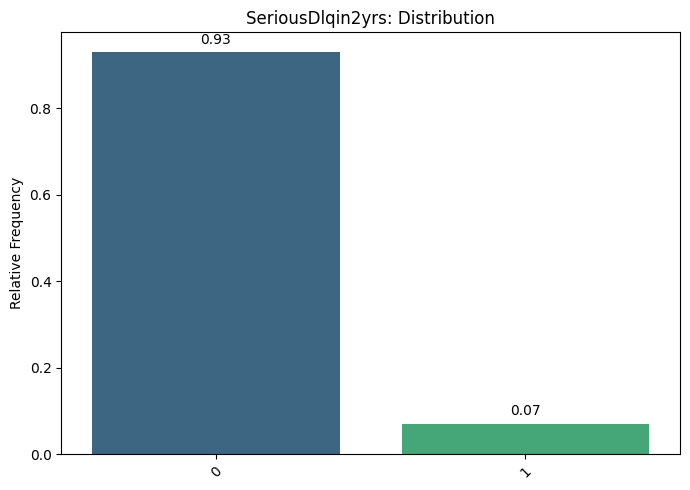

In [15]:
viz.plot_multiple_categorical_distributions(train_set, [target], relative=True)

Problemitas... Este target está muy muy desbalanceado.

No quiero hacer SMOTE porque creo que introduciría demasiados datos sintéticos. Mis dos opciones son:
- Hacer un Under Sampling
- Entrenar los modelos tal cual, ajustando el hiperparámetro "class_weight" y maximizar la métrica "balanced_accuracy" (porque Negocio - el enunciado - no dice lo contrario).
- Usar como métricas la precisión de la clase mayoritaria o el recall de la minoritaria o viceversa.

### Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.

#### Variables numéricas

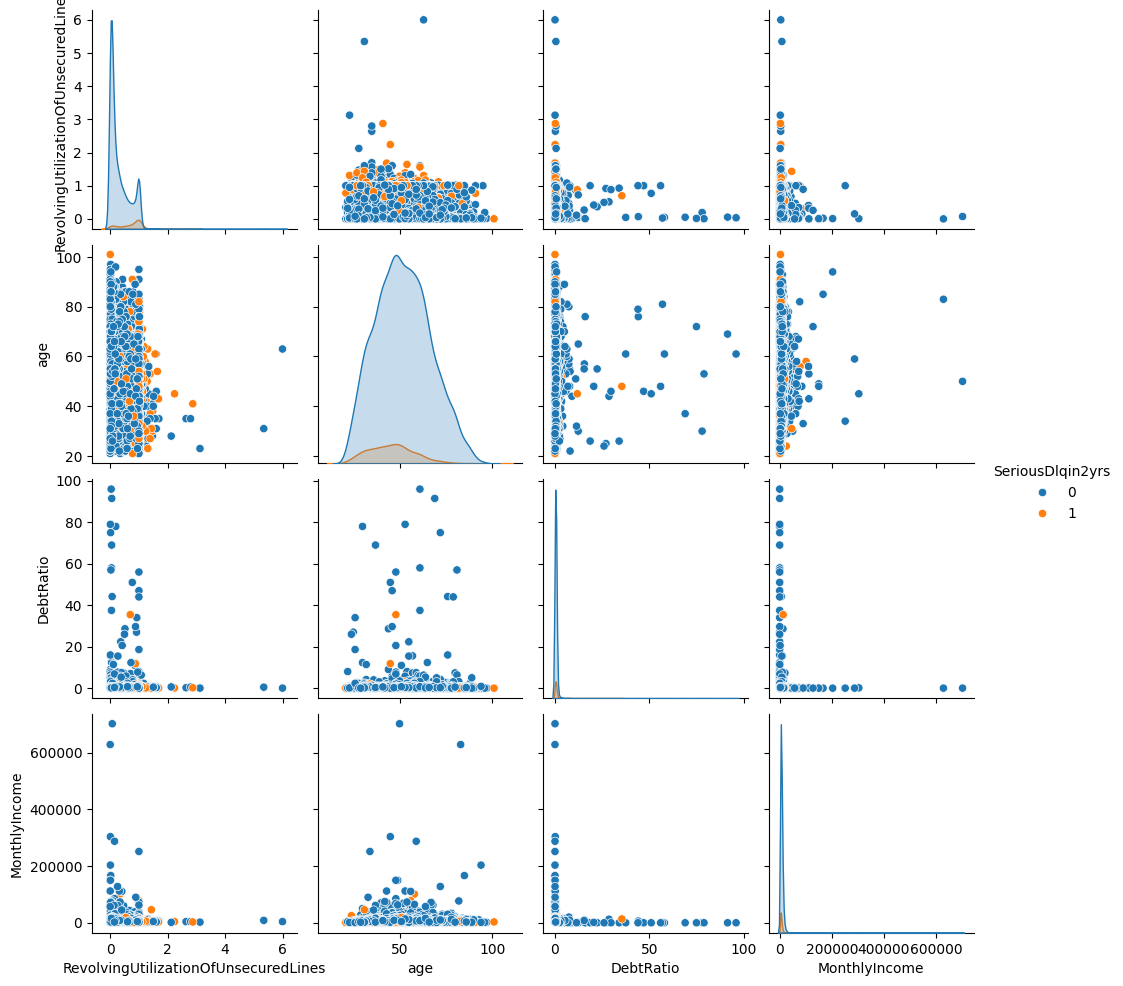

In [16]:
sns.pairplot(train_set[num_features + [target]], hue=target)

Esta gráfica da poca información debido (probablemente) al desbalanceo de clase. La distribución de probabilidad de "age" tal vez de algo de información porque aunque están superpuestas no parecen paralelas. De las otras tres no se ve demasiado. Y viendo por parejas las varaibles numéricas no se puede distinguir mucha relación en esas nubes de puntos.

Voy a hacer un poco más de zoom utilizando mis propias funciones

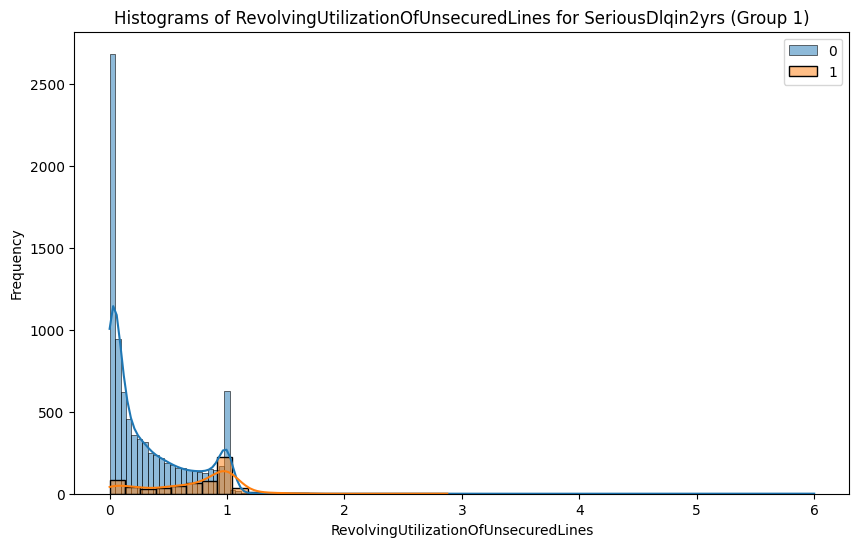

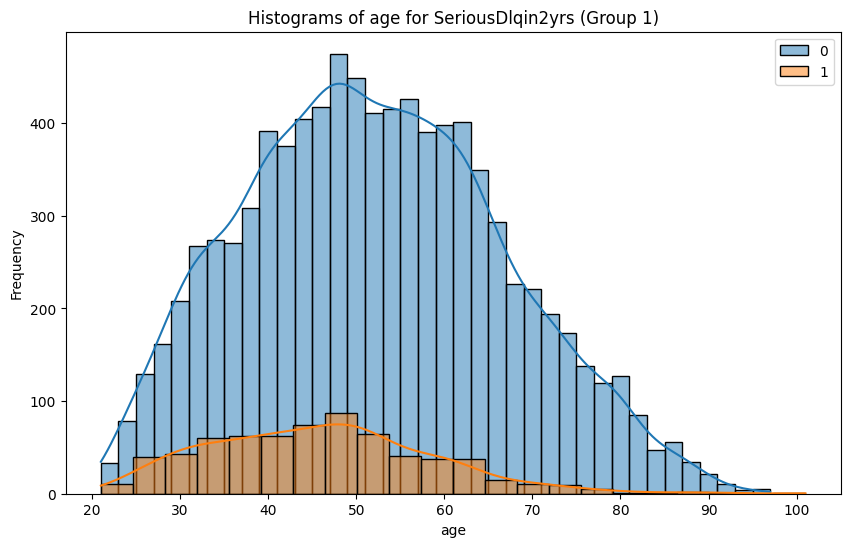

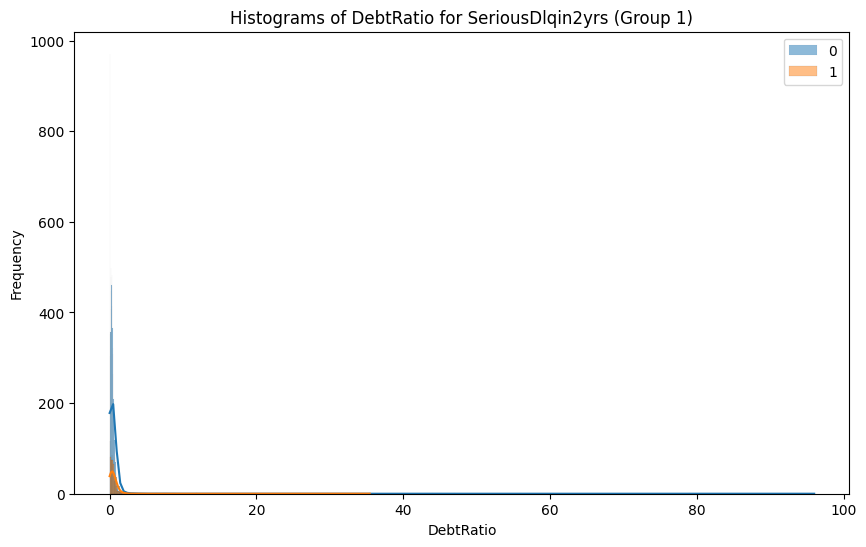

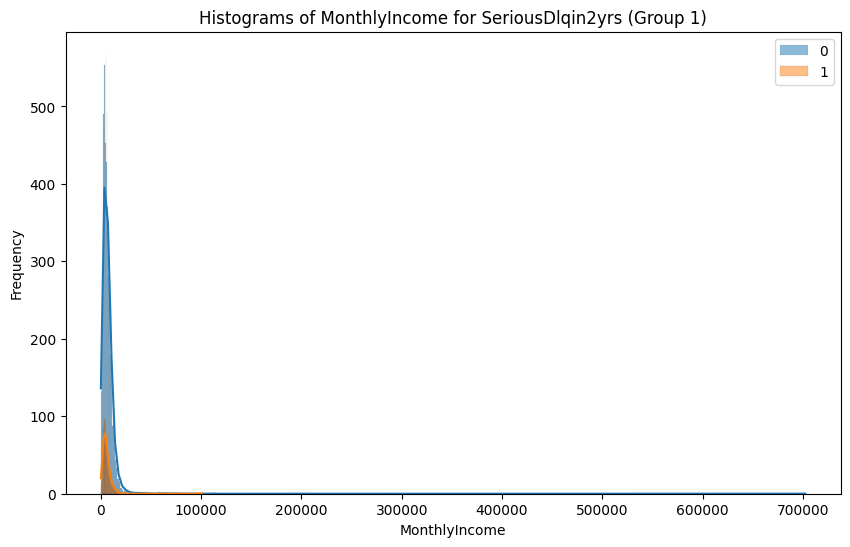

In [17]:
for feature in num_features:
    viz.plot_histograms_grouped(train_set, target, feature, group_size=2)

Después de ver esto ahora me parecen interesantes "age" y "RevolvingUtilizationOfUnsecuredLines" así que voy a dejar las otras fuera por el momento.

No es que no sean importantes pero me parece que lo son menos.

In [18]:
# Features numéricas que me parecen menos interesantes
num_features_segunda = ['DebtRatio', 'MonthlyIncome']

# Selección de features numéricas mediante inspección visual
num_features_visual = [col for col in num_features if col not in num_features_segunda]
num_features_visual

['RevolvingUtilizationOfUnsecuredLines', 'age']

#### Análisis variables categóricas

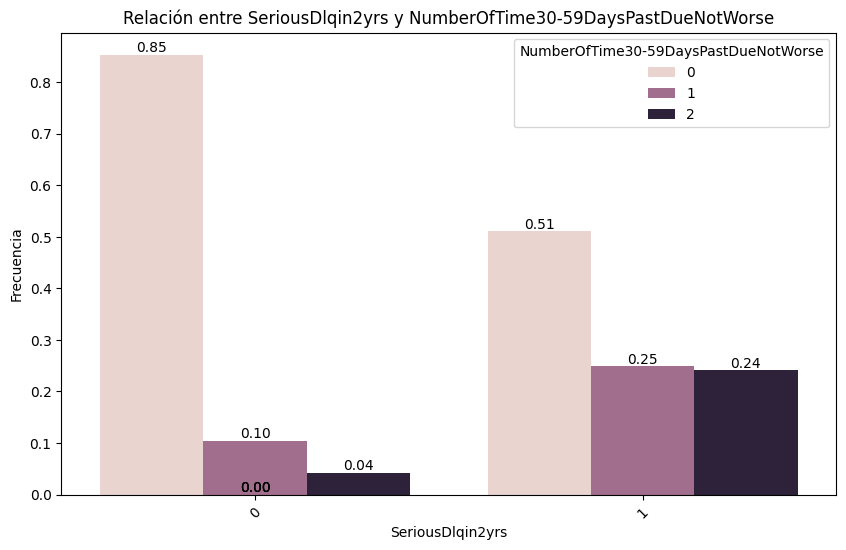

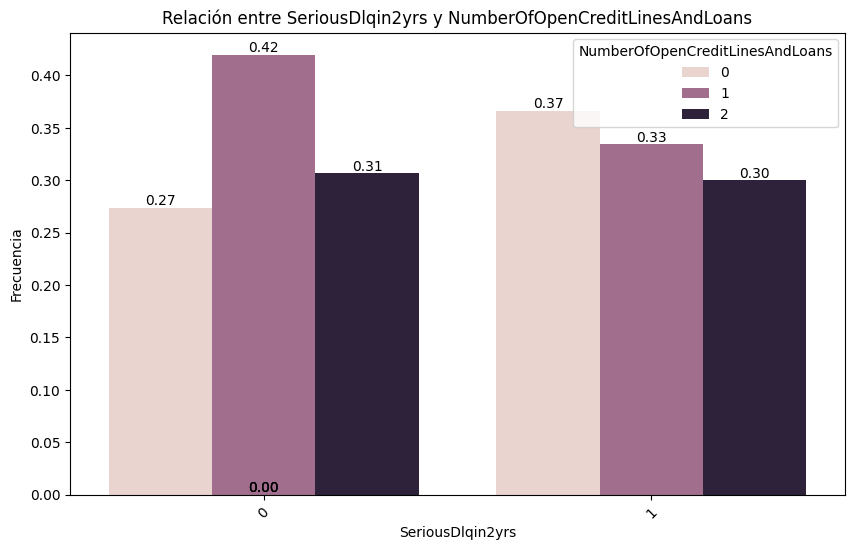

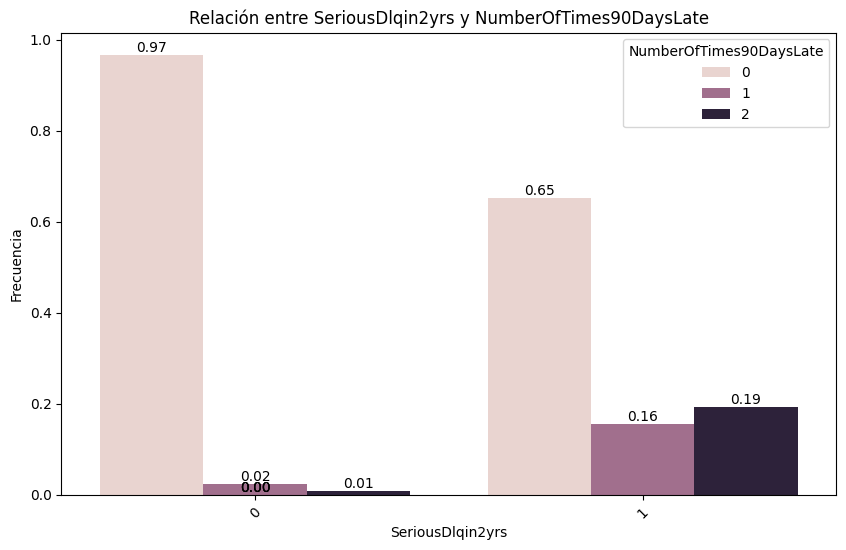

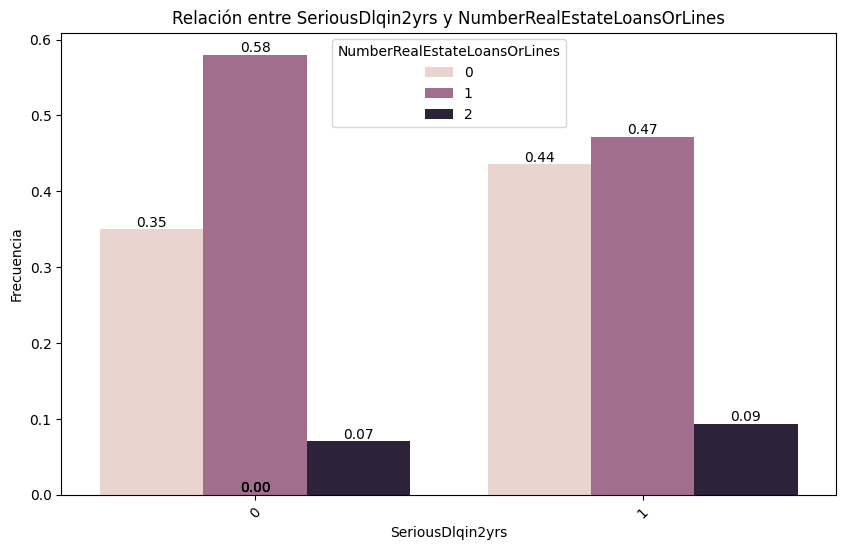

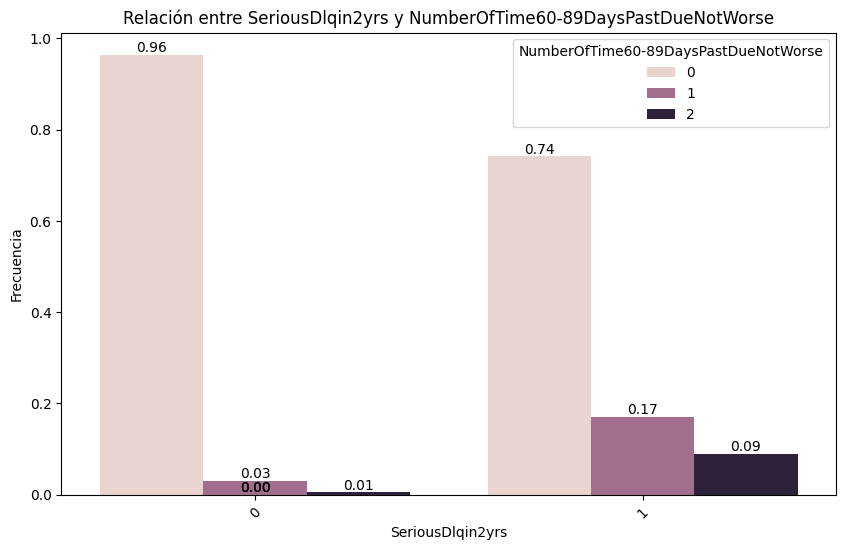

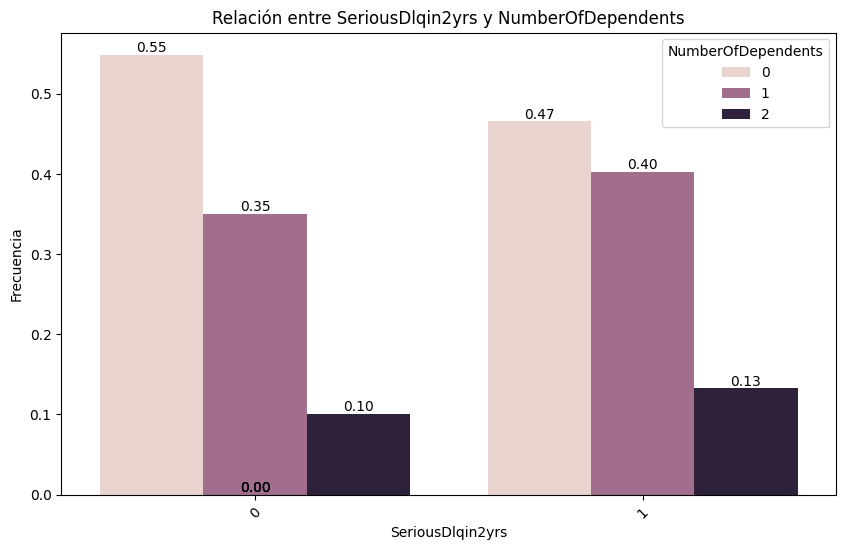

In [19]:
for feature in cat_features:
    viz.plot_categorical_relationship(train_set, target, feature, relative_freq=True)
    # viz.plot_absolute_categorical_relationship_and_contingency_table(train_set, target, feature)
    

De estas graficas de relación entre categorias con el target todas me parecen interesantes. Sin embargo, por tener la mayor similitud (de forma visual) voy a decantarme por dejar "NumberOfDependents" como una feature categórica de segunda.


In [20]:
# Feature categórica que me parece menos interesantes
cat_features_segunda = ['NumberOfDependents']

# Selección de features numéricas mediante inspección visual
cat_features_visual = [col for col in cat_features if col not in cat_features_segunda]
cat_features_visual

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse']

### Correlación

~~Como todas mis variables están representadas numéricamente (que no es lo mismo que decir si son numéricas o categóricas), voy a hacer un análisis de correlación y colinealidades. ~~

Tenemos aquí un problema de clasificaicón, así que no tiene sentido hacer análisis de correlación con el target. Podría si quiero hacer análisis de colinealidad aunque si estoy un poco "zorro" y pienso de antes que solo probaré modelos de árboles esto ni siquiera me haría falta.

In [58]:
# correlation map de todas las features
# plt.figure(figsize=(15, 15))
# sns.heatmap(train_set.corr(numeric_only=True), annot=True, linewidths=.5, fmt='.3f');

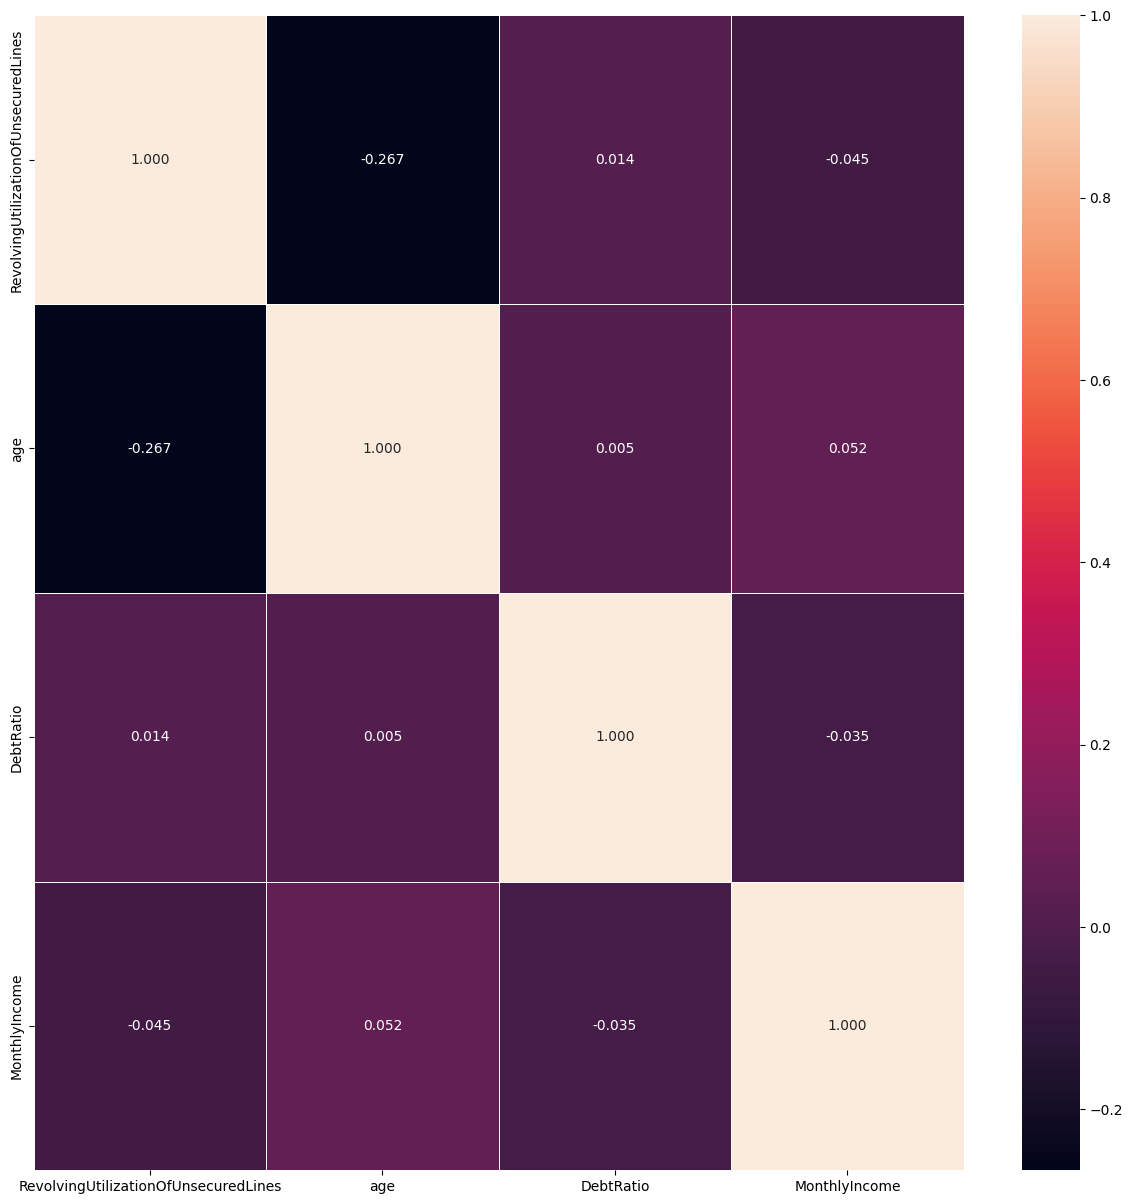

In [59]:
# colinealidad de la features numéricas
plt.figure(figsize=(15, 15))
sns.heatmap(train_set[num_features].corr(numeric_only=True), annot=True, linewidths=.5, fmt='.3f');

In [23]:
num_features_visual

['RevolvingUtilizationOfUnsecuredLines', 'age']

Con esta nueva información veo que no hay colinealidades entre features, y me mantengo en mi decisión de que las dos únicas variables numéricas que me parecen interesantes son ['RevolvingUtilizationOfUnsecuredLines', 'age']


In [24]:
print(num_features_visual)
print(cat_features_visual)

['RevolvingUtilizationOfUnsecuredLines', 'age']
['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse']


Todas las features están representadas numéricamente pero sus escalas son muy diferentes, y no hemos echado tampoco un vistazo a sus distribuciones. Lo hago ahora, aunque creo que habría que haberlo hecho antes.


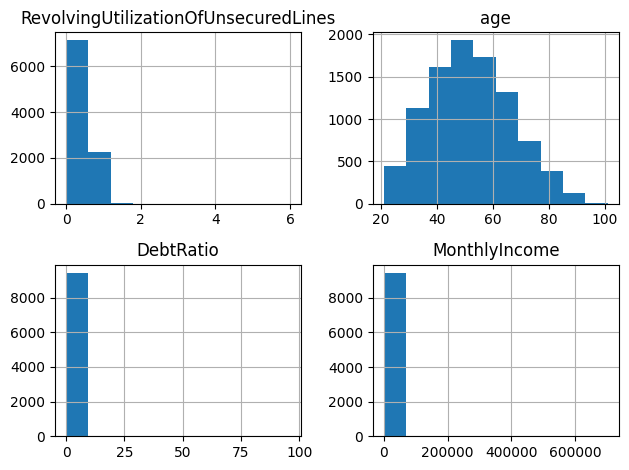

In [25]:
train_set[num_features].hist()
plt.tight_layout()

*Salvo Age todas necesitan un "empujoncito", pero voy a generar dos train_sets*

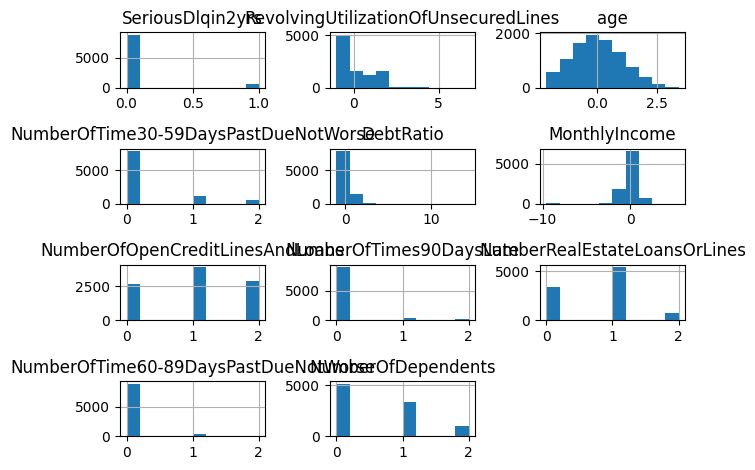

In [26]:
train_set_scaled = train_set.copy()
valid_set_scaled = valid_set.copy()

for feat in num_features:
    if feat != "age":
        # A todas les aplicafo log(x+1) porque tienen ceros
        train_set_scaled[feat] = np.log1p(train_set_scaled[feat]) 
        valid_set_scaled[feat] = np.log1p(valid_set_scaled[feat])
        
scaler = StandardScaler()
train_set_scaled[num_features] = scaler.fit_transform(train_set_scaled[num_features])
valid_set_scaled[num_features] = scaler.transform(valid_set_scaled[num_features])

# Nuevo histogramas
train_set_scaled.hist();
plt.tight_layout()

Debratio no ha mejorado mucho pero así se va a quedar.

In [27]:
train_set_scaled.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,9452.000000,9.452000e+03,9.452000e+03,9452.000000,9.452000e+03,9.452000e+03,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.070250,1.165194e-17,1.533545e-16,0.226196,3.909037e-17,4.916366e-16,1.026238,0.076598,0.716251,0.062421,0.560516
std,0.255581,1.000053e+00,1.000053e+00,0.535127,1.000053e+00,1.000053e+00,0.765175,0.337502,0.589021,0.284166,0.672981
min,0.000000,-1.028382e+00,-2.089829e+00,0.000000,-9.997402e-01,-9.562434e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-8.918200e-01,-7.182553e-01,0.000000,-5.479076e-01,-4.164911e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-3.735577e-01,-3.246823e-02,0.000000,-1.327912e-01,8.012838e-02,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,8.221419e-01,7.218975e-01,0.000000,3.110385e-01,5.559430e-01,2.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,6.762812e+00,3.396467e+00,2.000000,1.433671e+01,5.525755e+00,2.000000,2.000000,2.000000,2.000000,2.000000


In [28]:
# Diccionari de sets de X
X_train_dict = {}
X_valid_dict = {}

X_train_scaled_dict = {}
X_valid_scaled_dict = {}

# Sets X e y 
y_train_scaled = train_set_scaled[target]
y_valid_scaled = valid_set_scaled[target]

In [29]:
# Set con todas las features
X_train_scaled_dict['all'] = train_set_scaled.drop(columns=[target])
X_valid_scaled_dict['all'] = valid_set_scaled.drop(columns=[target])


In [30]:
# Train de features visual
X_train_scaled_dict['visual'] = train_set_scaled.drop(columns=[target])[num_features_visual + cat_features_visual]
X_valid_scaled_dict['visual'] = valid_set_scaled.drop(columns=[target])[num_features_visual + cat_features_visual]


### Selección de features numéricas mediante SelectKBest y ANOVA, selección de features categóricas mediante Mutual Information 

In [31]:
target_cats = train_set[target].unique()
print('ANOVA: (f_val, p_val)', end='\n---\n')
for feat in num_features:
    # Obtener el valor de cada feature númerica según el valor de target
    cat_per_target = [train_set[train_set[target] == target_val][feat] for target_val in target_cats] 
    # Separar todos los elementos de la lista con "*" y pasárselos como argumento a la función
    f_val, p_val = stats.f_oneway(*cat_per_target)
    print(f'{feat}: ({f_val}, {p_val})')
                                                    

ANOVA: (f_val, p_val)
---
RevolvingUtilizationOfUnsecuredLines: (788.2699079381871, 1.1619033140969135e-166)
age: (105.85743073415172, 1.0693542743053706e-24)
DebtRatio: (7.407423526632416e-05, 0.9931331620967166)
MonthlyIncome: (6.124269705596405, 0.013351252034858858)


In [32]:
#### Test ANOVA sobre las features escaladas

target_cats = train_set_scaled[target].unique()
print('ANOVA: (f_val, p_val)', end='\n---\n')
for feat in num_features:
    # Obtener el valor de cada feature númerica según el valor de target
    cat_per_target = [train_set_scaled[train_set_scaled[target] == target_val][feat] for target_val in target_cats] 
    # Separar todos los elementos de la lista con "*" y pasárselos como argumento a la función
    f_val, p_val = stats.f_oneway(*cat_per_target)
    print(f'{feat}: ({f_val}, {p_val})')
                                                    

ANOVA: (f_val, p_val)
---
RevolvingUtilizationOfUnsecuredLines: (774.4987314666819, 6.771576124667353e-164)
age: (105.85743073415173, 1.0693542743053706e-24)
DebtRatio: (12.636672193939066, 0.000380100440286605)
MonthlyIncome: (16.118871196747275, 5.994815124424166e-05)


`MMMMM... Los resultados son diferentes sobre los datos escalados o no escalados, entonces ¿en qué momento hago el escalado y aplico la selección de features mediante métricas?` 

Si el valor de p-value está por debajo de 1- Nivel de significación deseado, entonces podemos aceptar la hipótesis alternativa de que existe relación entre las variables a ese nivel de significación.

`Existe una forma de obtener las mejores k variables numéricas en función de su ANOVA con un target categórico:`

`f_classif realiza un test ANOVA`

La técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930, constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre la media de una variable continua. Es por lo tanto el test estadístico para emplear cuando se desea comparar las medias de dos o más grupos.

In [33]:
num_features

['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']

In [34]:
# Existe una forma de obtener las mejores k variables numéricas en 
# función de su **ANOVA con un target categórico
X_train_tmp = train_set[num_features]
y_train_tmp = train_set[target]

selector = SelectKBest(f_classif, k=2)
X_kbest = selector.fit_transform(X_train_tmp, y_train_tmp)
X_train_kbest = pd.DataFrame(X_kbest, columns=selector.get_feature_names_out())
display(X_train_kbest.head())

# Features escogidas con ANOVA
num_features_KBest = X_train_kbest.columns.to_list()
num_features_KBest

,RevolvingUtilizationOfUnsecuredLines,age
0,0.039187,61.0
1,0.919317,41.0
2,0.253718,49.0
3,0.249462,26.0
4,0.224520,76.0


['RevolvingUtilizationOfUnsecuredLines', 'age']

De momento la selección coincide con la misma que yo había hecho visualemente. 

In [35]:
# MI = Mutual Informationn para las variables categóricas
for feat in cat_features:
    print(f"MI({feat}, {target}):", mutual_info_score(train_set[feat], train_set[target]))

MI(NumberOfTime30-59DaysPastDueNotWorse, SeriousDlqin2yrs): 0.023411961613871907
MI(NumberOfOpenCreditLinesAndLoans, SeriousDlqin2yrs): 0.001537163294169086
MI(NumberOfTimes90DaysLate, SeriousDlqin2yrs): 0.03559443700711639
MI(NumberRealEstateLoansOrLines, SeriousDlqin2yrs): 0.0015725675121187957
MI(NumberOfTime60-89DaysPastDueNotWorse, SeriousDlqin2yrs): 0.020504339500262474
MI(NumberOfDependents, SeriousDlqin2yrs): 0.0009633014981185739


De aquí voy a hacer una selección de solo tres features catergóricas.

In [36]:
# Selección de features mediante Mutual Information
cat_features_MI = ['NumberOfTime30-59DaysPastDueNotWorse', 
                   'NumberOfTimes90DaysLate', 
                   'NumberOfTime60-89DaysPastDueNotWorse']

In [37]:
num_features_KBest

['RevolvingUtilizationOfUnsecuredLines', 'age']

In [38]:
train_set_scaled.drop(columns=[target])

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
2031,-0.874478,0.653319,0,-0.200151,-0.561868,1,0,1,0,0
10352,1.582026,-0.718255,0,-0.494387,-0.281987,0,0,0,0,0
497,-0.123051,-0.169626,0,-0.258908,1.075675,2,0,1,0,0
10341,-0.136666,-1.746936,0,1.120754,-2.120694,0,0,0,0,0
4043,-0.217401,1.681999,0,0.275163,-0.534140,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
4371,-0.384604,0.653319,0,0.787143,0.392640,1,0,1,0,0
5767,-0.872690,0.859055,0,-0.615452,1.263456,1,0,1,0,0
7494,1.746897,-1.541200,0,-0.999740,-1.020865,0,0,0,0,2
11693,1.636906,-0.032468,2,0.722738,-0.134498,2,0,1,0,0


In [39]:
# Añadir set al diccionario
X_train_scaled_dict['ANOVA_MI'] = train_set_scaled.drop(columns=[target])[num_features_KBest + cat_features_MI]
X_valid_scaled_dict['ANOVA_MI'] = valid_set_scaled.drop(columns=[target])[num_features_KBest + cat_features_MI]


### Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)

In [40]:
# Baselines
lr_base = LogisticRegression(max_iter=1000)
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

lr_base.fit(X_train_scaled_dict['all'], y_train_scaled)
rf_base.fit(X_train_scaled_dict['all'], y_train_scaled)

print(X_train_scaled_dict['all'].columns)
print(lr_base.coef_)
print(rf_base.feature_importances_)


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')
[[ 0.69127718 -0.25334408  0.56438264  0.02864096 -0.05597833  0.27572383
   1.16251734  0.13285417  0.68759139  0.08971699]]
[0.21478042 0.13672003 0.04474092 0.18501949 0.17057539 0.03543896
 0.10720065 0.02475424 0.04500412 0.03576578]


Empleando `SelectFromModel`

In [41]:
# El modelo debe tener un atributo feature_importances_ o un atributo coef_
selector_lr = SelectFromModel(estimator=lr_base, threshold='mean') 
selector_rf = SelectFromModel(estimator=rf_base, threshold='mean') 

selector_lr.fit(X_train_scaled_dict['all'], y_train_scaled)
selector_rf.fit(X_train_scaled_dict['all'], y_train_scaled)

print(selector_lr.get_feature_names_out())
print(selector_rf.get_feature_names_out())

['RevolvingUtilizationOfUnsecuredLines'
 'NumberOfTime30-59DaysPastDueNotWorse' 'NumberOfTimes90DaysLate'
 'NumberOfTime60-89DaysPastDueNotWorse']
['RevolvingUtilizationOfUnsecuredLines' 'age' 'DebtRatio' 'MonthlyIncome'
 'NumberOfTimes90DaysLate']


In [42]:
# No creo que haga falta transformarlo en DataFrame pero asfí queda más bonito
X_train_scaled_dict['intrinsic_lr'] = pd.DataFrame(selector_lr.transform(X_train_scaled_dict['all']),
                                                   columns=selector_lr.get_feature_names_out())
X_valid_scaled_dict['intrinsic_lr'] = pd.DataFrame(selector_lr.transform(X_valid_scaled_dict['all']),
                                                   columns=selector_lr.get_feature_names_out())
             
X_train_scaled_dict['intrinsic_rf'] = pd.DataFrame(selector_rf.transform(X_train_scaled_dict['all']),
                                                   columns=selector_rf.get_feature_names_out())
X_valid_scaled_dict['intrinsic_rf'] = pd.DataFrame(selector_rf.transform(X_valid_scaled_dict['all']),
                                                   columns=selector_rf.get_feature_names_out())                                      


Notar que la selección mediante un modelo (intrinseca) es diferente según el modelo que hayamos empleado. Para Logistic Regresion las features seleccionadas son mayormente categóricas, y para RandomForest han sido más importantes las numéricas.

### Selección de las mejores features empleando RFE (Recursive Feature Elimination)

Eliminación recursiva

In [43]:
# step=1 elimina de una en una
rfe_lr = RFE(estimator=lr_base, n_features_to_select=5, step=1) 
rfe_rf = RFE(estimator=rf_base, n_features_to_select=5, step=1) 

rfe_lr.fit(X_train_scaled_dict['all'], y_train_scaled)
rfe_rf.fit(X_train_scaled_dict['all'], y_train_scaled)

print('RFE LogisticRegression:')
display(pd.DataFrame(rfe_lr.ranking_, columns=['ranking'], index=X_train_scaled_dict['all'].columns).sort_values('ranking'))

print('RFE RandomForest:')
display(pd.DataFrame(rfe_rf.ranking_, columns=['ranking'], index=X_train_scaled_dict['all'].columns).sort_values('ranking'))

RFE LogisticRegression:


,ranking
RevolvingUtilizationOfUnsecuredLines,1
NumberOfTime30-59DaysPastDueNotWorse,1
NumberOfOpenCreditLinesAndLoans,1
NumberOfTimes90DaysLate,1
NumberOfTime60-89DaysPastDueNotWorse,1
age,2
NumberRealEstateLoansOrLines,3
NumberOfDependents,4
MonthlyIncome,5
DebtRatio,6


RFE RandomForest:


,ranking
RevolvingUtilizationOfUnsecuredLines,1
age,1
DebtRatio,1
MonthlyIncome,1
NumberOfTimes90DaysLate,1
NumberOfTime60-89DaysPastDueNotWorse,2
NumberOfTime30-59DaysPastDueNotWorse,3
NumberOfOpenCreditLinesAndLoans,4
NumberOfDependents,5
NumberRealEstateLoansOrLines,6


In [44]:
X_train_scaled_dict['RFE_lr'] = pd.DataFrame(rfe_lr.transform(X_train_scaled_dict['all']), 
                                             columns = rfe_lr.get_feature_names_out())
X_valid_scaled_dict['RFE_lr'] = pd.DataFrame(rfe_lr.transform(X_valid_scaled_dict['all']), 
                                             columns = rfe_lr.get_feature_names_out())

X_train_scaled_dict['RFE_rf'] = pd.DataFrame(rfe_rf.transform(X_train_scaled_dict['all']), 
                                             columns = rfe_rf.get_feature_names_out())
X_valid_scaled_dict['RFE_rf'] = pd.DataFrame(rfe_rf.transform(X_valid_scaled_dict['all']), 
                                             columns = rfe_rf.get_feature_names_out())


### Selección de las mejores features empleando SFS (Sequential Feature Selector)



In [45]:
kwargs = {'n_features_to_select': 5, 
          'cv': 5, 
          'scoring': 'balanced_accuracy',
          'n_jobs': -1
          }

sfs_lr = SequentialFeatureSelector(estimator=lr_base, **kwargs)
sfs_rf = SequentialFeatureSelector(estimator=rf_base, **kwargs)

sfs_lr.fit(X_train_scaled_dict['all'], y_train_scaled)
sfs_rf.fit(X_train_scaled_dict['all'], y_train_scaled)

print('SFS LogisticRegresion features:', sfs_lr.get_feature_names_out())
print('SFS RandomForest features:', sfs_rf.get_feature_names_out())

SFS LogisticRegresion features: ['RevolvingUtilizationOfUnsecuredLines' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans' 'NumberOfTimes90DaysLate'
 'NumberOfTime60-89DaysPastDueNotWorse']
SFS RandomForest features: ['RevolvingUtilizationOfUnsecuredLines' 'NumberOfOpenCreditLinesAndLoans'
 'NumberOfTimes90DaysLate' 'NumberOfTime60-89DaysPastDueNotWorse'
 'NumberOfDependents']


In [46]:
X_train_scaled_dict['SFS_lr'] = pd.DataFrame(sfs_lr.transform(X_train_scaled_dict['all']), 
                                             columns = sfs_lr.get_feature_names_out())
X_valid_scaled_dict['SFS_lr'] = pd.DataFrame(sfs_lr.transform(X_valid_scaled_dict['all']), 
                                             columns = sfs_lr.get_feature_names_out())

X_train_scaled_dict['SFS_rf'] = pd.DataFrame(sfs_rf.transform(X_train_scaled_dict['all']), 
                                             columns = sfs_rf.get_feature_names_out())
X_valid_scaled_dict['SFS_rf'] = pd.DataFrame(sfs_rf.transform(X_valid_scaled_dict['all']), 
                                             columns = sfs_rf.get_feature_names_out())

### Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

Para realizar una selección de las mejores características mediante un sistema de hard voting, podemos combinar las selecciones de las difere. Básicamente, se seleccionarán aquellas características que son elegidas con mayor frecuencia por los métodos previos. 

Primero, recolectamos las características seleccionadas por cada uno de los métodos disponibles en tu diccionario. Para simplificar, creamos un DataFrame donde cada fila represente una característica y cada columna represente si esa característica fue seleccionada o no por uno de los métodos.

Luego, aplicamos el sistema de "hard voting": cuenta cuántos métodos seleccionaron cada característica y define un umbral para seleccionar las características finales (por ejemplo, selecciona aquellas que hayan sido elegidas por la mayoría de los métodos).

In [47]:
# Inicializa un DataFrame donde cada fila representará una característica
features = X_train_scaled_dict['all'].columns
df_voting = pd.DataFrame(index=features)

# Crea una columna por cada método indicando si la característica fue seleccionada o no
for method in X_train_scaled_dict.keys():
    selected_features = X_train_scaled_dict[method].columns
    df_voting[method] = features.isin(selected_features).astype(int)

# Añade una columna con el conteo de métodos que seleccionaron cada característica
df_voting['vote_count'] = df_voting.sum(axis=1)
display(df_voting)

# Define el umbral (por ejemplo, la mayoría de los métodos)
num_methods = len(X_train_scaled_dict) - 1  # Restamos 1 porque 'all' contiene todas las características
threshold = num_methods // 2 # threshold = 4 (para la mayoría de los métodos)

# Selecciona las características que fueron elegidas por al menos el umbral
features_hard_voting = df_voting[df_voting['vote_count'] > threshold].index.tolist()
print("Características seleccionadas mediante Hard Voting:", features_hard_voting)


,all,visual,ANOVA_MI,intrinsic_lr,intrinsic_rf,RFE_lr,RFE_rf,SFS_lr,SFS_rf,vote_count
RevolvingUtilizationOfUnsecuredLines,1,1,1,1,1,1,1,1,1,9
age,1,1,1,0,1,0,1,0,0,5
NumberOfTime30-59DaysPastDueNotWorse,1,1,1,1,0,1,0,0,0,5
DebtRatio,1,0,0,0,1,0,1,0,0,3
MonthlyIncome,1,0,0,0,1,0,1,1,0,4
NumberOfOpenCreditLinesAndLoans,1,1,0,0,0,1,0,1,1,5
NumberOfTimes90DaysLate,1,1,1,1,1,1,1,1,1,9
NumberRealEstateLoansOrLines,1,1,0,0,0,0,0,0,0,2
NumberOfTime60-89DaysPastDueNotWorse,1,1,1,1,0,1,0,1,1,7
NumberOfDependents,1,0,0,0,0,0,0,0,1,2


Características seleccionadas mediante Hard Voting: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']


In [48]:
# Features escogidas mediante hard voting
X_train_scaled_dict['hard_voting'] = X_train_scaled_dict['all'][features_hard_voting]
X_valid_scaled_dict['hard_voting'] = X_valid_scaled_dict['all'][features_hard_voting]

### Ver todos los set que tenemos de entrenamiento

In [49]:
# Ver la selección de features que he hecho
for key, value in X_train_scaled_dict.items():
    print(f'{key} ({len(value.columns)} features): {value.columns.to_list()}')


all (10 features): ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
visual (7 features): ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse']
ANOVA_MI (5 features): ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
intrinsic_lr (4 features): ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
intrinsic_rf (5 features): ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'Numbe

### 3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las listas obtenidas anteriormente. Es decir tendrás numero_listas*3 medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

In [50]:
# Modelos a comparar, baselines
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBoostClassifier': XGBClassifier()
}

kwargs = {'cv': 5, 
          'scoring': 'balanced_accuracy',
          'n_jobs': -1
          }

# Almacenar los resultados
cv_results = {}

# Realizar la validación cruzada para cada modelo y cada selección de características
for model_name, model in models.items():
    for feature_set_name, X_train_scaled in X_train_scaled_dict.items():
        # if feature_set_name == 'all':
        #     continue  # Saltar la lista con todas las características
        
        scores = cross_val_score(model, X_train_scaled, y_train_scaled, **kwargs)
        cv_results[f'{model_name}_{feature_set_name}'] = scores.mean()
        print(f'{model_name} con {feature_set_name}: Recall medio = {scores.mean():.5f}')

# Encontrar la mejor combinación
best_combination = max(cv_results, key=cv_results.get)
best_model_name, best_feature_set_name = best_combination.split('_', 1)
print(f'\nEl mejor modelo es {best_model_name} con las características seleccionadas por {best_feature_set_name}')


LogisticRegression con all: Recall medio = 0.59487
LogisticRegression con visual: Recall medio = 0.59615
LogisticRegression con ANOVA_MI: Recall medio = 0.59069
LogisticRegression con intrinsic_lr: Recall medio = 0.58610
LogisticRegression con intrinsic_rf: Recall medio = 0.58334
LogisticRegression con RFE_lr: Recall medio = 0.59426
LogisticRegression con RFE_rf: Recall medio = 0.58334
LogisticRegression con SFS_lr: Recall medio = 0.59626
LogisticRegression con SFS_rf: Recall medio = 0.59707
LogisticRegression con hard_voting: Recall medio = 0.59545
RandomForestClassifier con all: Recall medio = 0.59621
RandomForestClassifier con visual: Recall medio = 0.58974
RandomForestClassifier con ANOVA_MI: Recall medio = 0.58759
RandomForestClassifier con intrinsic_lr: Recall medio = 0.59972
RandomForestClassifier con intrinsic_rf: Recall medio = 0.58845
RandomForestClassifier con RFE_lr: Recall medio = 0.61002
RandomForestClassifier con RFE_rf: Recall medio = 0.58845
RandomForestClassifier con 

### 4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra validación.

In [51]:
best_feature_set_name

'SFS_rf'

In [52]:
best_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
    }

kwargs = {'cv': 5, 
          'scoring': 'balanced_accuracy',
          'n_jobs': -1
          }

# GridSearchCV para optimizar los hiperparámetros
grid_search = GridSearchCV(best_model, param_grid, **kwargs)
grid_search.fit(X_train_scaled_dict[best_feature_set_name], y_train_scaled)

print(f'Mejores hiperparámetros: {grid_search.best_params_}')
print(f'Mejor recall medio en validación cruzada: {grid_search.best_score_:.4f}')


Mejores hiperparámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Mejor recall medio en validación cruzada: 0.6270


In [53]:
# Evaluación en el conjunto de validación
y_valid_pred = grid_search.best_estimator_.predict(X_valid_scaled_dict[best_feature_set_name])

# Calcular el recall en el conjunto de prueba
balanced_accuracy = recall_score(y_valid_scaled, y_valid_pred, average='macro')
print(f'Recall medio en el conjunto de prueba: {balanced_accuracy:.4f}')


Recall medio en el conjunto de prueba: 0.6106


In [55]:
print(classification_report(y_valid_scaled, y_valid_pred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2198
           1       0.27      0.28      0.27       166

    accuracy                           0.90      2364
   macro avg       0.61      0.61      0.61      2364
weighted avg       0.90      0.90      0.90      2364



Los resultados de train y validación son bastante similares. Pero los resultados no son buenos la verdad... esto es porque los datos estaban muy desbalanceados. Hubiera sido interesante, como he escrito al principio tratar ese desbalanceo y hacer el mismo análisis (ahora no lo hago por tiempo, pero lo dejo en pendiente).

Esto es importante porque en este caso lo que a mi me parece más interesante es descubrir los 1s.


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [57]:
# Aplicar PCA para reducir dimensionalidad. Retenemos el 95% de la varianza explicada
pca = PCA(n_components=0.95)
X_train_scaled_dict['pca_95'] = pca.fit_transform(X_train_scaled_dict['all'])
X_valid_scaled_dict['pca_95'] = pca.transform(X_valid_scaled_dict['all'])

# Entrenar el modelo ganador usando los datos transformados por PCA
best_model = grid_search.best_estimator_  
best_model.fit(X_train_scaled_dict['pca_95'], y_train_scaled)

# Paso 4: Evaluar el modelo usando los datos de prueba
y_valid_pred = best_model.predict(X_valid_scaled_dict['pca_95'])

# Paso 5: Imprimir las métricas de evaluación
report_pca = classification_report(y_valid_scaled, y_valid_pred)
print(report_pca)


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2198
           1       0.52      0.10      0.16       166

    accuracy                           0.93      2364
   macro avg       0.73      0.54      0.56      2364
weighted avg       0.91      0.93      0.91      2364



En este caso, y con una varianza acumulada del 95% el resultado ha empeorado.